# Gradient Blending - Testing

Based on the Facebook paper [What Makes Training Multi-modal Classification Networks Hard?](https://research.fb.com/wp-content/uploads/2020/06/What-Makes-Training-Multi-modal-Classification-Networks-Hard.pdf)

Note the GradientBlending code comes from [@zmuellr on fast.ai](https://forums.fast.ai/t/combining-tabular-images-in-fastai2-and-should-work-with-almost-any-other-type/73197) and the MixedDL coode from his [notebook here](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/fastinference/02_Mixed_DL.ipynb)

First let's install grab the libraries we need:

In [2]:
from fastai2.tabular.all import *
from fastai2.vision.all import *
#from fastai2.medical.imaging import *

## The General Approach

Approaching this problem will be pretty straight forward. We're going to wrap a `TabDataLoader` and a `TfmdDL` (Or Vision `DataLoader`) together. To do this properly they need to share 3 functions:
  * `one_batch`
  * `shuffle_fn`
  * `show_batch`
  
Let's build our two `DataLoaders` real fast and then we'll explore why. We'll make it a very small subset for the sake of example:

## Data

Smaller (3GB) extract of 224x224 images used from here: https://www.kaggle.com/arroqc/siic-isic-224x224-images

In [3]:
path = Path("data/siic_melanoma")

In [4]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')

In [5]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


I want to adjust the `image_name` to include either the `train` or `test` folder, this will help with inference:

In [6]:
train_df['image_name'] = 'train/' + train_df['image_name'].astype(str)
test_df['image_name'] = 'test/' + test_df['image_name'].astype(str)

train_df.head(3)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,train/ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,train/ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,train/ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0


In [7]:
#df.groupby('target').sum()
#df.groupby('target').sum().values[1]/(df.groupby('target').sum().values[0]+df.groupby('target').sum().values[1])

In [8]:
len(train_df)

33126

Lets create a balanced dataset

In [9]:
pos_len = len(train_df.query('target==1'));pos_len

584

In [10]:
df = train_df.loc[train_df.target==0].sample(pos_len).copy()
df = pd.concat([df, train_df.loc[train_df.target==1].copy()])
len(df)

1168

## Tabular `DataLoader`

Let's build our `TabularDataLoader`. We'll want to define our `procs`, `cat` and `cont` names

In [11]:
cols = ['image_name', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target']
df = df[cols]
procs = [Categorify, FillMissing, Normalize]
cat_names  = ['sex', 'anatom_site_general_challenge']
cont_names = ['age_approx']
splitter = RandomSplitter(seed=42)
splits = splitter(range_of(df))
to = TabularPandas(df, procs, cat_names, cont_names,
                  y_names='target', y_block=CategoryBlock(),
                  splits=splits)

In [12]:
tab_dl = to.dataloaders(bs=8)

Next we'll move onto Vision

## Vision

Vision is a bit of a funky one. We're going to follow the `DataBlock` seen [here](https://www.kaggle.com/avirdee/fastai2-dicom-starter) but we're going to adjust the splitter a bit to push everything to the `train`:

In [13]:
# get_x = lambda x:path/f'{x[0]}.dcm'
# get_y=ColReader('target')
# batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
# blocks = (ImageBlock(cls=PILDicom), CategoryBlock(vocab=[0,1]))
# melanoma = DataBlock(blocks=blocks,
#                    get_x=get_x,
#                    splitter=splitter,
#                    item_tfms=Resize(128),
#                    get_y=ColReader('target'),
#                    batch_tfms=batch_tfms)

In [14]:
df.head(3)

,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
20470,train/ISIC_6228575,male,45.0,upper extremity,unknown,benign,0
4783,train/ISIC_1537566,female,40.0,torso,unknown,benign,0
1754,train/ISIC_0626986,male,55.0,lower extremity,unknown,benign,0


In [15]:
get_x = lambda x:path/f'{x[0]}.png'
get_y=ColReader('target')
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
#blocks = (ImageBlock(cls=PILDicom), CategoryBlock(vocab=[0,1]))

melanoma = DataBlock(blocks    = (ImageBlock, CategoryBlock(vocab=[0,1])),
                   get_x = get_x,
                   get_y     = ColReader('target'),
                   #item_tfms = RandomResizedCrop(128, min_scale=0.35), 
                   #batch_tfms=Normalize.from_stats(*imagenet_stats)
                   splitter = splitter,
                   item_tfms = Resize(128),
                   batch_tfms = batch_tfms
                  )

In [16]:
vis_dl = melanoma.dataloaders(df, bs=8)

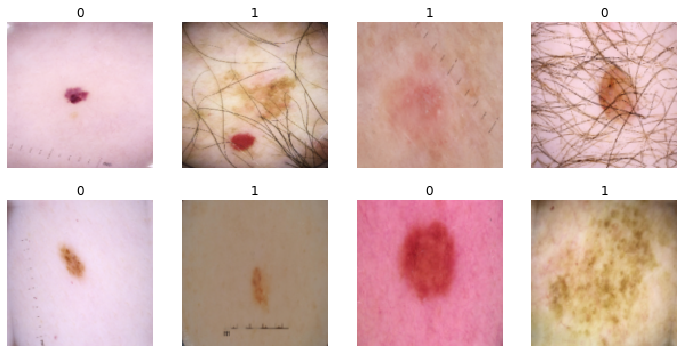

In [17]:
vis_dl.show_batch()

Now we grabbed `[0]` to get the `train` `DataLoader`:

In [18]:
type(vis_dl[0])

fastai2.data.core.TfmdDL

# Combining the `DataLoaders`

Now for the part we all want and care about, how do we combine these two `DataLoaders`? We're going to build a "mock" `DataLoader` instead. It will have the same basic jobs as the regular `DataLoader`, but each time we call something for one, we will call it for both `DataLoaders`. We can do this as any time we iterate over the `DataLoader`, what we actually do is call `dl.one_batch` (during training, etc) so we just need to make those three functions I mentioned above. First, let's make our base.

What we want to do is override both `DataLoader`'s `shuffle_fn`, as what this function does is return a list of index's to grab. If the index's are the same, the data is the same, and that's all there is to it. In this particular case, we're going to be calling their `shuffle_fn`, etc multiple times, so we need to keep track of who actually is being called. We'll store this in a value called `count`. When it's 0, we'll grab some index's. When it's 1, we will return those index's (this is done at the beginning of each epoch to shuffle the `DataLoader`

## MixedDL

In [19]:
from fastai2.data.load import _FakeLoader, _loaders

In [20]:
class MixedDL():
    def __init__(self, tab_dl:TabDataLoader, vis_dl:TfmdDL, device='cuda:0'):
        "Stores away `tab_dl` and `vis_dl`, and overrides `shuffle_fn`"
        self.device = device
        tab_dl.shuffle_fn = self.shuffle_fn
        vis_dl.shuffle_fn = self.shuffle_fn
        self.dls = [tab_dl, vis_dl]
        self.count = 0
        self.fake_l = _FakeLoader(self, False, 0, 0)
    
    def __len__(self): return len(self.dls[0])
        
    def shuffle_fn(self, idxs):
        "Generates a new `rng` based upon which `DataLoader` is called"
        if self.count == 0: # if we haven't generated an rng yet
            self.rng = self.dls[0].rng.sample(idxs, len(idxs))
            self.count += 1
            return self.rng
        else:
            self.count = 0
            return self.rng
        
    def to(self, device): self.device = device

And that's all there is to it. How do we check? Let's check the `DataLoader`'s index's

In [21]:
vis_dl[0].get_idxs()[:10]

[406, 12, 5, 454, 177, 154, 557, 334, 828, 243]

In [22]:
tab_dl[0].get_idxs()[:10]

[219, 15, 440, 6, 374, 25, 501, 165, 180, 267]

Right now we see they are different

In [23]:
mixed_dl = MixedDL(tab_dl[0], vis_dl[0])

In [24]:
mixed_dl.dls[0].get_idxs()[:10]

[905, 318, 182, 597, 635, 700, 452, 731, 538, 757]

In [25]:
mixed_dl.dls[1].get_idxs()[:10]

[905, 318, 182, 597, 635, 700, 452, 731, 538, 757]

And now we can see our data is being shuffled the exact same way! Great! 

## One Batch

What more can we do?

We need to get our `one_batch` properly working, so let's focus on that. We'll make use of `fastcore`'s `patch` ability to save some room.

For our `grab_batch` function, we'll want to return 3 `xs` and one `y`:
  * Categorical
  * Continuous
  * Image
  
The first two are stored in the first two index's of the tabular batch, the final in the x of the vision batch. Let's write that:

But we have to do that in a few different ways. Specifically, this occurs in the `__iter__` function, and `one_batch` will grab the `first`. So let's build our `__iter__`:

In [26]:
@patch
def __iter__(dl:MixedDL):
    "Iterate over your `DataLoader`"
    z = zip(*[_loaders[i.fake_l.num_workers==0](i.fake_l) for i in dl.dls])
    for b in z:
        if dl.device is not None: 
            b = to_device(b, dl.device)
        batch = []
        batch.extend(dl.dls[0].after_batch(b[0])[:2])
        batch.append(dl.dls[1].after_batch(b[1][0]))
        try: # In case the data is unlabelled
            batch.append(b[1][1])
            yield tuple(batch)
        except:
            yield tuple(batch)

Now what did we do here? For us to iterate over everything nicely, we need to wrap it all in a `zip` (this is how the `__iter__` is on the original `DataLoader`. Then we want to return a set of `x` and `y`. 

But it's a little more than that. We need to run our `after_batch` transforms here, and before we do so, as we want those to be done on the GPU if possible, we need to (recursevly) convert all of our tensors to GPU via `to_device`. Finally we run the respective `after_batch` on each item needed. So now let's do `one_batch`:

In [27]:
@patch
def one_batch(x:MixedDL):
    "Grab a batch from the `DataLoader`"
    with x.fake_l.no_multiproc(): res = first(x)
    if hasattr(x, 'it'): delattr(x, 'it')
    return res

`one_batch` will need to call the first from the `DataLoader` (which is just `next(iter(dl))`), and if we are keeping track of an iterator, delete it. Finally returning our batch

And now let's see if it works:


In [28]:
batch = mixed_dl.one_batch()

Exception ignored in: <generator object MixedDL.__iter__ at 0x7f4de82b3e50>
RuntimeError: generator ignored GeneratorExit


In [29]:
batch[0]

tensor([[2, 5, 1],
        [1, 5, 1],
        [2, 1, 1],
        [2, 2, 1],
        [2, 5, 1],
        [2, 1, 1],
        [2, 5, 1],
        [2, 2, 1]], device='cuda:0')

In [30]:
batch[1]

tensor([[ 1.3616],
        [-0.5552],
        [ 1.6811],
        [-1.1942],
        [ 0.4032],
        [ 1.0421],
        [-0.2358],
        [ 1.0421]], device='cuda:0')

In [31]:
batch[2]

TensorImage([[[[0.4924, 0.4954, 0.5017,  ..., 0.4895, 0.5011, 0.5158],
          [0.4775, 0.4905, 0.5025,  ..., 0.4982, 0.5105, 0.5197],
          [0.4583, 0.4742, 0.4911,  ..., 0.5039, 0.5192, 0.5246],
          ...,
          [0.4555, 0.4135, 0.3821,  ..., 0.5267, 0.5137, 0.4996],
          [0.4544, 0.4144, 0.3805,  ..., 0.5377, 0.5181, 0.5015],
          [0.4466, 0.4050, 0.3760,  ..., 0.5567, 0.5356, 0.5175]],

         [[0.3667, 0.3637, 0.3694,  ..., 0.3573, 0.3743, 0.3859],
          [0.3513, 0.3619, 0.3715,  ..., 0.3566, 0.3786, 0.3890],
          [0.3346, 0.3471, 0.3603,  ..., 0.3585, 0.3751, 0.3905],
          ...,
          [0.2793, 0.2478, 0.2285,  ..., 0.3695, 0.3476, 0.3336],
          [0.2870, 0.2547, 0.2328,  ..., 0.3876, 0.3572, 0.3308],
          [0.2864, 0.2565, 0.2345,  ..., 0.4149, 0.3845, 0.3508]],

         [[0.3470, 0.3469, 0.3556,  ..., 0.3125, 0.3176, 0.3272],
          [0.3293, 0.3343, 0.3486,  ..., 0.3225, 0.3340, 0.3337],
          [0.3208, 0.3220, 0.3364,  .

In [32]:
batch[3]

TensorCategory([1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')

And now we see our batch returns what we want! What's left? Let's see if we can't merge our `show_batch`'s together:

## Show Batch

`show_batch` is probably the easiest out of all of them. We can try to improve it by say splitting up the batch and whatnot, or we can keep it easy and simple. Let's show a batch (which operates on the same batch in both) for both of our `DataLoaders`:

In [33]:
@patch
def show_batch(x:MixedDL):
    "Show a batch from multiple `DataLoaders`"
    for dl in x.dls:
        dl.show_batch()

Does it work? Let's see

,sex,anatom_site_general_challenge,age_approx_na,age_approx,target
0,male,torso,False,75.000000,1
1,female,torso,False,45.000000,0
2,male,head/neck,False,79.999999,1
3,male,lower extremity,False,35.000000,1
4,male,torso,False,60.000000,0
5,male,head/neck,False,70.000000,1
6,male,torso,False,50.000000,0
7,male,lower extremity,False,70.000000,0


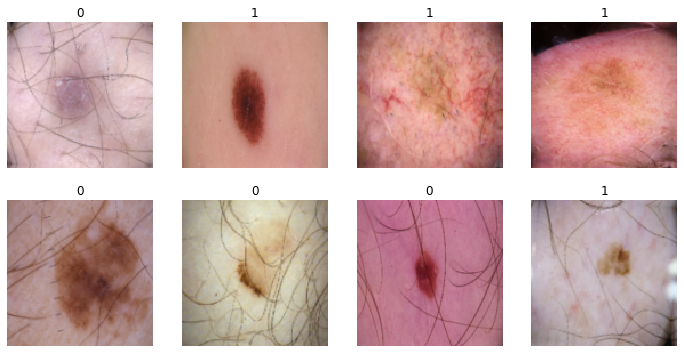

In [34]:
mixed_dl.show_batch()

It does! Right away! You now have all the bits needed to fully train your model. Have fun!

## Get Train + Valid MixedDL

In [35]:
train_mixed_dl = MixedDL(tab_dl[0], vis_dl[0])
valid_mixed_dl = MixedDL(tab_dl[1], vis_dl[1])
mixed_dls = DataLoaders(train_mixed_dl, valid_mixed_dl).cuda()

## Testing: Train Tab
Make sure our tabular model trains

In [36]:
tab_learn = tabular_learner(tab_dl, metrics=accuracy)

In [37]:
tab_learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.675225,0.634807,0.643777,00:01
1,0.668103,0.632977,0.643777,00:00
2,0.646353,0.630978,0.635193,00:00


In [38]:
#tab_learn.show_results()

## Testing: Train Vision
Make sure our vision model trains

In [39]:
vis_learn = cnn_learner(vis_dl, resnet34, metrics=accuracy, pretrained=False)

In [40]:
vis_learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.058633,1.639851,0.682403,00:05
1,0.845432,0.799230,0.768240,00:05
2,0.823077,0.522713,0.733906,00:05


In [41]:
#vis_learn_p = cnn_learner(vis_dl, resnet34, metrics=accuracy, pretrained=True)

In [42]:
#vis_learn_p.fit_one_cycle(2, lr_max=5e-4)

## Joint Model

In [41]:
o=mixed_dl.one_batch(); len(o)

Exception ignored in: <generator object MixedDL.__iter__ at 0x7f4de05e6b50>
RuntimeError: generator ignored GeneratorExit


4

In [44]:
# hooks = {}
# for name, module in tab_learn.model.named_modules():
#     hooks[name] = module.register_forward_hook(hook_fn)
    
# tt = tab_learn.model(o[0], o[1])
# tt

In [45]:
# def printnorm(self, input, output):
#     # input is a tuple of packed inputs
#     # output is a Tensor. output.data is the Tensor we are interested
#     print('Inside ' + self.__class__.__name__ + ' forward')
#     print('')
#     print('input: ', type(input))
#     print('input[0]: ', type(input[0]))
#     print('output: ', type(output))
#     print('')
#     print('input size:', input[0].size())
#     print('output size:', output.data.size())
#     print('output norm:', output.data.norm())


# tab_learn.model.layers[2][0].register_forward_hook(printnorm)

# out = tab_learn.model(o[0], o[1])

## PyTorch Hooks
Create 2 hooks that will extract the input to the layer just before the classifier layer

In [42]:
global glb_tab_logits
def get_tab_logits(self, inp, out):
    global glb_tab_logits
    glb_tab_logits = inp
    #return None

global glb_vis_logits
def get_vis_logits(self, inp, out):
    global glb_vis_logits
    glb_vis_logits = inp
    #return None

## Define Multi-Modal Model

#### Classifiers
Used the default vision and tabular classifiers from fastai and just grabbed the logits from each (via pytorch hooks) which are then concated and fed into a linear layer (which is our mixed classifier)

#### PyTorch Hooks
Note, I'm not sure if I'm grabbing the right thing with the `get_tab_logits` and `get_vis_logits` hooks, only grabbing the weight. Its trains ok tho, so maybe its fine...

In [117]:
class TabVis(nn.Module):
    def __init__(self, tab_model, vis_model, num_classes=2): 
        super(TabVis, self).__init__()
        self.tab_model = tab_model
        self.vis_model = vis_model
        
        self.mixed_cls = nn.Linear(512+100, num_classes)
        self.tab_cls = nn.Linear(100, num_classes)
        self.vis_cls = nn.Linear(512, num_classes)
        
        #self.print_handle = self.tab_model.layers[2][0].register_forward_hook(printnorm)
        self.tab_handle = self.tab_model.layers[2][0].register_forward_hook(get_tab_logits)
        self.vis_handle = self.vis_model[-1][-1].register_forward_hook(get_vis_logits)
    
    def remove_my_hooks(self):
        self.tab_handle.remove()
        self.vis_handle.remove()
        #self.print_handle.remove()
        return None
        
    def forward(self, x_cat, x_cont, x_im):
        # Tabular Classifier
        tab_pred = self.tab_model(x_cat, x_cont)        
        
        # Vision Classifier
        vis_pred = self.vis_model(x_im)
        
        # Logits
        tab_logits = glb_tab_logits[0]   # Only grabbling weights, not bias'
        vis_logits = glb_vis_logits[0]   # Only grabbling weights, not bias'
        mixed = torch.cat((tab_logits, vis_logits), dim=1)
        
        # Mixed Classifier
        mixed_pred = self.mixed_cls(mixed)
        return (tab_pred, vis_pred, mixed_pred)

## Gradient Blending, loss function

Same as : https://forums.fast.ai/t/gradient-blending-for-multi-modal-models-in-progress/75645/3

In [118]:
def ModCELoss(pred, targ, ce=True):
    pred = pred.softmax(dim=-1)
    targ = targ.flatten().long()
    if ce:
        loss = F.cross_entropy(pred, targ)
    else:
        loss = F.binary_cross_entropy_with_logits(pred, targ)
    #loss = torch.mean(ce)
    return loss

class myGradientBlending(nn.Module):
    def __init__(self, tab_weight=0.0, visual_weight=0.0, tab_vis_weight=1.0, loss_scale=1.0, use_cel=True):
        "Expects weights for each model, the combined model, and an overall scale"
        super(myGradientBlending, self).__init__()
        self.tab_weight = tab_weight
        self.visual_weight = visual_weight
        self.tab_vis_weight = tab_vis_weight
        self.ce =  use_cel
        self.scale = loss_scale
        
    def forward(self, xb, yb):
        tab_out, visual_out, tv_out = xb
        targ = yb
        "Gathers `self.loss` for each model, weighs, then sums"
        tv_loss = ModCELoss(tv_out, targ, self.ce) * self.scale
        t_loss = ModCELoss(tab_out, targ, self.ce) * self.scale
        v_loss = ModCELoss(visual_out, targ, self.ce) * self.scale
        
        weighted_t_loss = t_loss * self.tab_weight
        weighted_v_loss = v_loss * self.visual_weight
        weighted_tv_loss = tv_loss * self.tab_vis_weight
        
        loss = weighted_t_loss + weighted_v_loss + weighted_tv_loss
        return loss

## Testing individual steps

In [119]:
#multi_model = TabVis(tab_learn.model, vis_learn.model)

In [120]:
#tab_pred, vis_pred, mixed_pred = multi_model(o[0], o[1] , o[2])

In [121]:
# gb_loss = myGradientBlending(tab_weight=0.333, visual_weight=0.333, vis_tab_weight=0.333, 
#                              loss_scale=1.0, use_cel=True)

# loss = gb_loss(tab_pred, vis_pred, mixed_pred, targ=o[3])
# loss

In [122]:
#loss.backward()

In [123]:
#multi_model.remove_my_hooks()

## Learner testing

In [124]:
# class Looky(Callback):
#     def after_pred(self):
#         return None
#         #print(len(self.pred))
#         #print(self.pred)

In [153]:
def t_accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
#     print(inp[0])
#     print(inp[0].argmax(dim=axis))
#     print(targ)
    pred,targ = flatten_check(inp[0].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def v_accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[1].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def tv_accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[2].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def weighted_accuracy(inp, targ, axis=-1, w_t=0.333, w_v=0.333, w_tv=0.333):
    t_inp = inp[0] * w_t
    v_inp = inp[1] * w_v
    tv_inp = inp[2] * w_tv
    inp_fin = (t_inp + v_inp + tv_inp)/3
    pred,targ = flatten_check(inp_fin.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

In [171]:
# Get uni-modal models, ugly but quick way to grab a tabular and vision model
v_model = cnn_learner(vis_dl, resnet34, metrics=accuracy, pretrained=False).model
t_model = tabular_learner(tab_dl, metrics=accuracy).model

# Create our Multi-Modal model
multi_model = TabVis(t_model, v_model)

# Set weights for each loss
tab_w = 0.15
vis_w = 0.6
tv_w = 0.25

# Initialise Loss
gb_loss = myGradientBlending(tab_weight=tab_w, visual_weight=vis_w, tab_vis_weight=tv_w, 
                             loss_scale=1.0, use_cel=True)

# Define accuracy weights
w_accuracy = partial(weighted_accuracy, w_t=tab_w, w_v=vis_w, w_tv=tv_w)

metrics = [t_accuracy,v_accuracy,tv_accuracy, w_accuracy]
cbs=[]

In [172]:
multi_learn = Learner(mixed_dls, multi_model, gb_loss, cbs=cbs, metrics=metrics)

Exception ignored in: <generator object MixedDL.__iter__ at 0x7f4dd03e2ed0>
RuntimeError: generator ignored GeneratorExit


SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=6.30957365501672e-05)

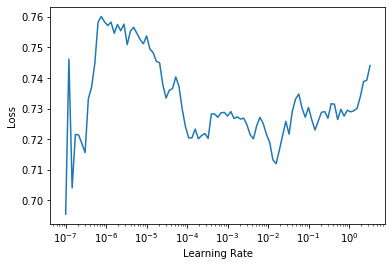

In [168]:
multi_learn.lr_find()

## Standard fit_one_cycle

In [169]:
multi_learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,t_accuracy,v_accuracy,tv_accuracy,weighted_accuracy,time
0,0.637136,0.587460,0.596566,0.725322,0.746781,0.729614,00:06
1,0.645878,0.589331,0.506438,0.738197,0.746781,0.738197,00:06
2,0.600083,0.551879,0.587983,0.763949,0.785408,0.776824,00:06


In [99]:
# Remove hooks from model (not sure if this is working)
multi_learn.model.remove_my_hooks()

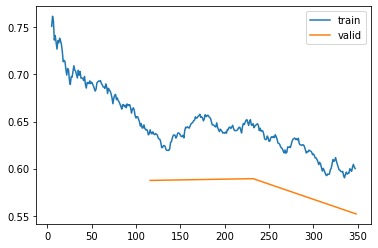

In [170]:
multi_learn.recorder.plot_loss()

## 1e-4, fit_one_cycle

In [173]:
multi_learn.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,t_accuracy,v_accuracy,tv_accuracy,weighted_accuracy,time
0,0.658144,0.669002,0.433476,0.618026,0.639485,0.626609,00:06
1,0.615297,0.587199,0.635193,0.708154,0.742489,0.712446,00:06
2,0.617624,0.571332,0.643777,0.746781,0.746781,0.742489,00:06


In [174]:
# Remove hooks from model (not sure if this is working)
multi_learn.model.remove_my_hooks()

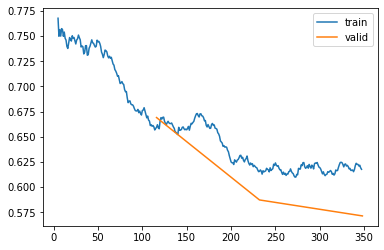

In [175]:
multi_learn.recorder.plot_loss()

# Mess

### Fastai Hooks

http://dev.fast.ai/callback.hook#HookCallback

In [69]:
# class VisCallback(HookCallback):
#     def __init__(self, modules=None, remove_end=True, detach=True, cpu=False):
#         super().__init__(modules, None, remove_end, False, detach, cpu)
#     def hook(self, m, i, o): return o
#     def after_batch(self):
#         if self.training:
#             test_eq(self.hooks.stored[0][0], 2*(self.pred-self.y)/self.pred.shape[0])
            
# # # Remember to keep history and gradients and figure out how to pass a module
# # vis_cb = VisCallback(modules=)

In [71]:
# for name, param in multi_model.vis_model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

# for name, param in multi_model.tab_model.named_parameters():
#     if param.requires_grad:
#          print(name, param.data)

for name, param in multi_model.mixed_cls.named_parameters():
    if param.requires_grad:
        print(name, param.data)

weight tensor([[ 0.0221, -0.0220,  0.0390,  ...,  0.0128,  0.0110,  0.0198],
        [-0.0017, -0.0351,  0.0266,  ...,  0.0389,  0.0383,  0.0288]],
       device='cuda:0')
bias tensor([0.0083, 0.0192], device='cuda:0')


## Ensembling ideas

In [66]:
# class MyEnsemble(nn.Module):
#     def __init__(self, modelA, modelB, nb_classes=10):
#         super(MyEnsemble, self).__init__()
#         self.modelA = modelA
#         self.modelB = modelB
#         # Remove last linear layer
#         self.modelA.fc = nn.Identity()
#         self.modelB.fc = nn.Identity()
        
#         # Create new classifier
#         self.classifier = nn.Linear(2048+512, nb_classes)
        
#     def forward(self, x):
#         x1 = self.modelA(x.clone())  # clone to make sure x is not changed by inplace methods
#         x1 = x1.view(x1.size(0), -1)
#         x2 = self.modelB(x)
#         x2 = x2.view(x2.size(0), -1)
#         x = torch.cat((x1, x2), dim=1)
        
#         x = self.classifier(F.relu(x))
#         return x

In [68]:
# class Vgg16(torch.nn.Module):
# Vgg16 taken from here https://github.com/chenyuntc/pytorch-book/blob/master/chapter08-neural_style/PackedVGG.py
#     def __init__(self):
#         super(Vgg16, self).__init__()
#         features = list(vgg16(pretrained=True).features)[:23]
#         # the 3rd, 8th, 15th and 22nd layer of \ 
#         # self.features are: relu1_2,relu2_2,relu3_3,relu4_3
#         self.features = nn.ModuleList(features).eval()

#     def forward(self, x):
#         results = []
#         for ii, model in enumerate(self.features):
#             x = model(x)
#             if ii in {3, 8, 15, 22}:
#                 results.append(x)

#         vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
#         return vgg_outputs(*results)

### Inspect the gradients

In [91]:
list(multi_model.mixed_cls.named_parameters())[0][1].grad.data

tensor([[ 1.0850e-02,  5.6407e-03, -8.8697e-03,  ..., -1.4478e-02,
          1.2854e-05,  2.9971e-04],
        [-1.0850e-02, -5.6407e-03,  8.8697e-03,  ...,  1.4478e-02,
         -1.2855e-05, -2.9971e-04]], device='cuda:0')

In [92]:
list(multi_model.tab_model.named_parameters())[11][1].grad.data

tensor([[ 0.0212,  0.0105, -0.0163,  0.0277, -0.0016,  0.0124,  0.0091, -0.0148,
         -0.0211,  0.0165,  0.0340, -0.0258,  0.0365,  0.0175, -0.0068,  0.0057,
          0.0108, -0.0168, -0.0247, -0.0238, -0.0056,  0.0447,  0.0055,  0.0087,
          0.0488,  0.0220, -0.0365,  0.0192, -0.0041,  0.0333,  0.0508, -0.0425,
          0.0162,  0.0341,  0.0379, -0.0123,  0.0041, -0.0024,  0.0337,  0.0160,
         -0.0195,  0.0319,  0.0455,  0.0107,  0.0215,  0.0286,  0.0347,  0.0366,
         -0.0042,  0.0515,  0.0195,  0.0195,  0.0085, -0.0107,  0.0337,  0.0128,
          0.0196,  0.0201,  0.0001,  0.0374, -0.0141,  0.0215,  0.0271,  0.0530,
          0.0279,  0.0247,  0.0012, -0.0293,  0.0244,  0.0211, -0.0049,  0.0117,
         -0.0344,  0.0492,  0.0409, -0.0228,  0.0280, -0.0136,  0.0305,  0.0129,
          0.0047,  0.0410,  0.0080,  0.0280, -0.0233, -0.0370,  0.0390,  0.0719,
          0.0262,  0.0403, -0.0007,  0.0205, -0.0077,  0.0066,  0.0057, -0.0040,
          0.0290,  0.0556,  

In [93]:
list(multi_model.vis_model.named_parameters())[113][1].grad.data

tensor([[-0.0096, -0.0558, -0.0477,  ..., -0.0685, -0.0698,  0.0297],
        [ 0.0096,  0.0558,  0.0477,  ...,  0.0685,  0.0698, -0.0297]],
       device='cuda:0')